In [19]:
import wfdb
from wfdb import processing

import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch

import neurokit2 as nk

import matplotlib.pyplot as plt

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
from kde import *


def make_grids(x, y):

    return np.c_[np.repeat(x, len(y), axis=0),


                 np.tile(y, len(x))]

In [22]:
def plot_ecg_signal(time, signal):
    plt.cla()
    plt.clf()
    plt.close()

    fig = plt.figure(figsize=(100, 5))
    ax = plt.axes()
    ax.plot(time, signal)
    # setup major and minor ticks
    min_t = int(np.min(time))
    max_t = round(np.max(time))
    major_ticks = np.arange(min_t, max_t+1)
    ax.set_xticks(major_ticks)
    # Turn on the minor ticks on
    ax.minorticks_on()
    # Make the major grid
    ax.grid(which='major', linestyle='-', color='red', linewidth='1.0')
    # Make the minor grid
    ax.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    return ax
# https://www.indigits.com/post/2022/10/ecg_python/

In [23]:
def getECGfeatures(tECG_R_Peaks, fss):
    out = pd.DataFrame()
    rrPoincart = pd.DataFrame()
    try:
        out = nk.hrv(tECG_R_Peaks, sampling_rate=fss)
        out = out.dropna(axis=1).reset_index(drop=True)
        out = out[np.isfinite(out).all(1)]
    except:
        print('getECGfeatures error: nk.hrv not work')
        return pd.DataFrame(), pd.DataFrame()
    try:
        rrIntv = processing.calc_rr(tECG_R_Peaks, fs=fss)
        rrIntv = np.array(rrIntv)
        rrIntv = rrIntv/np.int64(np.ceil(fss*1.0))
        rrPoincart = pd.DataFrame()
        rrPoincart['rrn'] = rrIntv[:-1]
        rrPoincart['rrn+1'] = rrIntv[1:]
        out['rrIntv_max'] = np.max(rrIntv)
        out['rrIntv_min'] = np.min(rrIntv)
        out['rrIntv_mean'] = np.mean(rrIntv)
        out['rrIntv_std'] = np.std(rrIntv)
        out['rrIntv_quantile25'] = np.quantile(rrIntv, 0.25)
        out['rrIntv_quantile50'] = np.quantile(rrIntv, 0.5)
        out['rrIntv_quantile75'] = np.quantile(rrIntv, 0.75)
        out['rrIntv_percentile25'] = np.percentile(rrIntv, 25)
        out['rrIntv_percentile50'] = np.percentile(rrIntv, 50)
        out['rrIntv_percentile75'] = np.percentile(rrIntv, 75)
        zt = pd.DataFrame()
        zt['rrn'] = rrIntv
        out['rrIntv_MaxHistCounts'] = zt['rrn'].value_counts().values[0]
    except:
        print('getECGfeatures error: processing.calc_rr not work')
        return out, pd.DataFrame()
    try:
        values = np.vstack(rrPoincart[['rrn', 'rrn+1']].to_numpy())
        erakde = JitERAKDE(values, len(values)//10, 3, 0.6)
        eva = erakde.get_densities(values)
        out['erakde_max'] = np.max(eva)
        out['erakde_min'] = np.min(eva)
        out['erakde_mean'] = np.mean(eva)
        out['erakde_std'] = np.std(eva)
        out['erakde_quantile25'] = np.quantile(eva, 0.25)
        out['erakde_quantile50'] = np.quantile(eva, 0.5)
        out['erakde_quantile75'] = np.quantile(eva, 0.75)
        out['erakde_percentile25'] = np.percentile(eva, 25)
        out['erakde_percentile50'] = np.percentile(eva, 50)
        out['erakde_percentile75'] = np.percentile(eva, 75)
    except:
        print('getECGfeatures error: JitERAKDE')

    return out, rrPoincart

In [24]:
def processSubEcg(subEcgSignal, fss):
    try:
        preCleanProSignal, info = nk.ecg_process(
            subEcgSignal, sampling_rate=fss)
    except:
        print('processSubEcg ecg_process error')
        return []
    try:
        qualitysss = nk.ecg_quality(preCleanProSignal['ECG_Clean'],
                                    rpeaks=info['ECG_R_Peaks'],
                                    method='zhao2018',
                                    approach='fuzzy',
                                    sampling_rate=int(fss))
        if qualitysss == 'Unacceptable':
            print('Unacceptable ecg signal')
            return []
        if len(info['ECG_R_Peaks']) > 0:
            return info['ECG_R_Peaks']
        else:
            return []
    except:
        print('processSubEcg ecg_quality error')
        return []
    return []

# https://neuropsychology.github.io/NeuroKit/functions/ecg.html#neurokit2.ecg.ecg_quality

In [25]:
# Bandpass filter for ECG (0.5-50 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Notch filter to remove 50/60 Hz powerline interference


def notch_filter(data, notch_freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    w0 = notch_freq / nyquist
    b, a = iirnotch(w0, quality_factor)
    return filtfilt(b, a, data)

# Denoising process


def preprocess_ecg(ecg_signal, fs):
    # Step 1: Bandpass Filter
    ecg_bandpassed = bandpass_filter(ecg_signal, 0.5, 50, fs)

    # Step 2: Notch Filter
    ecg_notched = notch_filter(ecg_bandpassed, 50, fs)

    # Step 3: Moving Average (Optional)
    ecg_smoothed = np.convolve(ecg_notched, np.ones(3)/3, mode='same')

    return ecg_smoothed

In [26]:
path = 'M:\p08\p089002\p089002-2135-08-30-16-18'
tmp = wfdb.rdrecord(path, smooth_frames=False)
fss = np.int64(np.ceil(tmp.fs*1.0))
mainSignal = tmp.e_p_signal[0]
for zz in range(len(tmp.sig_name)):
    if tmp.sig_name[zz] == 'II':
        mainSignal = tmp.e_p_signal[zz]
        break
    elif tmp.sig_name[zz] == 'I':
        mainSignal = tmp.e_p_signal[zz]
    elif tmp.sig_name[zz] == 'III':
        mainSignal = tmp.e_p_signal[zz]

tmp = pd.DataFrame()
tmp['sig'] = mainSignal
tmp = tmp.dropna(subset=['sig']).reset_index(drop=True)
mainSignal = tmp['sig'].to_numpy()
cleanSignal = preprocess_ecg(mainSignal, fss)

In [27]:
print(cleanSignal.shape)
print(fss)

(492711,)
125


In [28]:
# 1min
windows = np.int64(fss)*60
subRange = 2

# 10min
windows = np.int64(windows*10)

subSig = cleanSignal[(subRange*windows):(((subRange+1)*windows))]

<Axes: xlabel='Time (sec)', ylabel='Amplitude'>

Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3301 ticks ([-30.0, ..., 630.0]),

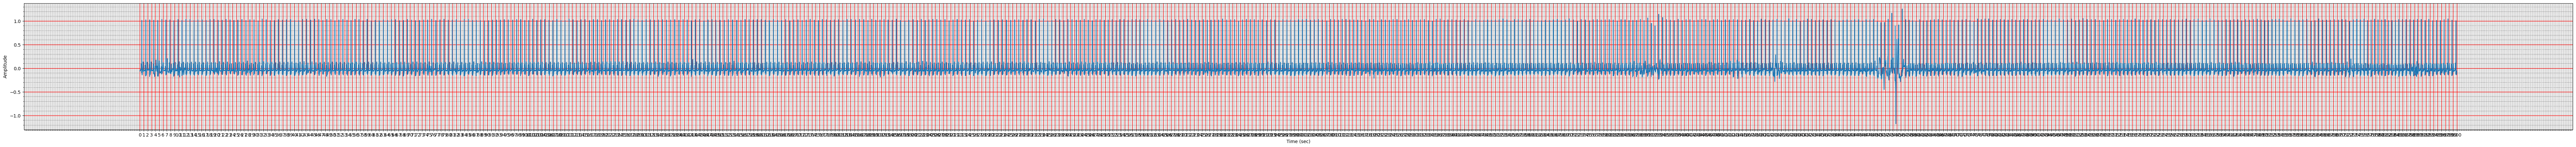

In [29]:
tsplot = np.arange(len(subSig)) / fss

plot_ecg_signal(tsplot, subSig)

In [30]:
tECG_R_Peaks = processSubEcg(subSig, fss)

In [31]:
print(tECG_R_Peaks.shape)

(586,)


In [32]:
s_hrv_indices, rrPoincart = getECGfeatures(tECG_R_Peaks, fss)
s_hrv_indices['subRange_'+str(windows)] = subRange


In [ ]:
s_hrv_indices

In [ ]:
s_hrv_indices.to_csv(path+'_ecg.csv',index=False)

In [33]:
saveText = ('ecg_rr_eraakde.png')
saveText = saveText.replace(' ', '')
saveText = saveText.replace('-', '_')
saveText = saveText.replace('.0_', '_')

try:
    values = np.vstack(rrPoincart[['rrn', 'rrn+1']].to_numpy())
    erakde = JitERAKDE(values, len(values)//10, 3, 0.6)
    rangPosin = 2.6
    densPosin = 256
    sizePosin = 1
    x = y = np.linspace(0., rangPosin, densPosin)
    grids = make_grids(x, y)
    densities = erakde.get_densities(grids)

    # =============================================
    plt.cla()
    plt.clf()
    plt.close()
    fig = plt.figure(figsize=(15/3, 9/3), dpi=360)
    plt.title('RR interval_KDE')
    # xyline = np.linspace(0.0, rangPosin, num=10)
    # plt.plot(xyline, xyline, c='lightgrey', ls='-', linewidth = 0.5)
    plt.scatter(grids[:, 0], grids[:, 1], s=sizePosin,
                c=densities, cmap='OrRd')  # hot
    plt.xlabel('RR n (s)')
    plt.ylabel('RR n+1 (s)')
    plt.grid()
    plt.colorbar()
    plt.savefig(saveText)
    plt.cla()
    plt.clf()
    plt.close()

except:
    print('plot kde error')